In [1]:
import numpy as np
import pandas as pd
from scipy import stats

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma
    
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activity,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [3]:
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

def cm_analysis(y_true, y_pred, labels, classes, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
                
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
#     sns.set_context("paper", rc={"font.scale":20,"font.size":20,"axes.titlesize":20,"axes.labelsize":20})   
    
    fig, ax = plt.subplots(figsize=figsize)
#     sns.set(font_scale=1.4)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cbar=False)
    plt.show()

In [4]:
data = read_data('/home/luishengjie/workspace/cg3002/har_cnn/data/actitracker_raw_strip.txt')
data.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Segment Signal

In [5]:
# Sliding window with 50% overlap
WINDOW_SIZE = 90

def windows(data, size):
    start = 0
    print(data.count())
    while start < data.count():
        yield start, start + size
        start += int(size / 2)
        
def segment_signal(data,window_size = WINDOW_SIZE):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["timestamp"], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(data["timestamp"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [6]:
segments, labels = segment_signal(data)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

1098204


/home/luishengjie/anaconda3/envs/deeplearning/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
print(reshaped_segments.shape)
print(labels.shape)
print(data['timestamp'].count())

(24403, 1, 90, 3)
(24403, 6)
1098204


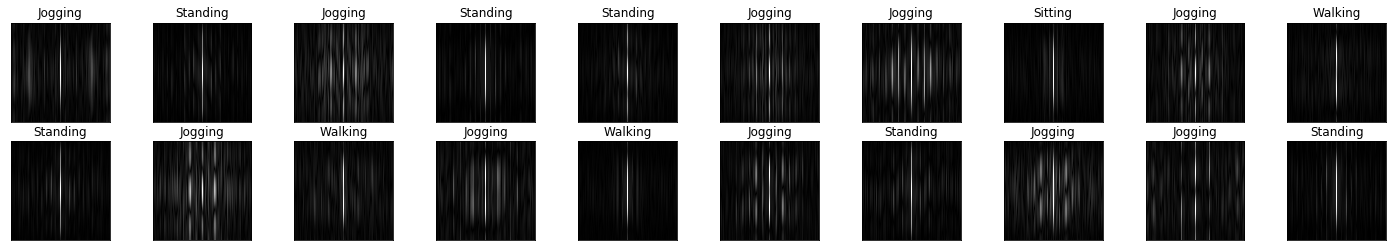

In [8]:
# Create Activity Image
from activity_image import algorithm1
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

SCALE = 400
IMAGE_SHAPE = (299,299)
NS = reshaped_segments.shape[-1]

activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    signal = reshaped_segments[idx * SCALE][0]
    signal = np.transpose(signal, (1, 0))
    magnitude_spectrum = algorithm1(NS, signal, IMAGE_SHAPE)
    plt.imshow(magnitude_spectrum, cmap='gray')
    label = np.argmax(labels[idx  * SCALE])
    ax.set_title(activities[label])


## Manipulate Features

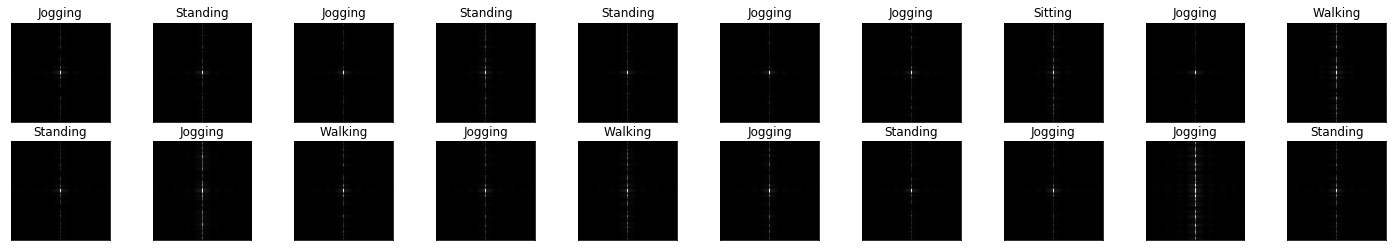

In [9]:
def enhance_signal_features(signal):
    """ Incoming signal: 3 x WINDOW_SIZE (x,y,z)
    """
    # Average Resultant distance
    mag = np.mean(np.sqrt(np.square(signal[0]) + 
                                   np.square(signal[1]) + np.square(signal[2])))
#     mag = np.sqrt(np.sum(np.square(signal[0]) + np.square(signal[1]) + np.square(signal[2])))
    mag_arr = np.ones((1, WINDOW_SIZE)) * mag
    
    # Mean Signal
    x_mean = np.sum(signal[0]) / WINDOW_SIZE
    y_mean = np.sum(signal[1]) / WINDOW_SIZE    
    z_mean = np.sum(signal[2]) / WINDOW_SIZE    
    x_mean_arr = np.ones((1, WINDOW_SIZE)) * x_mean
    y_mean_arr = np.ones((1, WINDOW_SIZE)) * y_mean
    z_mean_arr = np.ones((1, WINDOW_SIZE)) * z_mean
    
    # Avg dist from mean
    avg_dist_x = np.mean(np.abs(signal[0] - x_mean_arr))
    avg_dist_x_arr = np.ones((1, WINDOW_SIZE)) * avg_dist_x
    avg_dist_y = np.mean(np.abs(signal[1] - y_mean_arr))
    avg_dist_y_arr = np.ones((1, WINDOW_SIZE)) * avg_dist_y   
    avg_dist_z = np.mean(np.abs(signal[2] - z_mean_arr))
    avg_dist_z_arr = np.ones((1, WINDOW_SIZE)) * avg_dist_z
    
    # Standard Deviation
    std_x = np.std(signal[0])
    std_y = np.std(signal[1])
    std_z = np.std(signal[2])
    
    std_x_arr = np.ones((1, WINDOW_SIZE)) * std_x
    std_y_arr = np.ones((1, WINDOW_SIZE)) * std_y
    std_z_arr = np.ones((1, WINDOW_SIZE)) * std_z
    
    # Append additional features to signal
    enhanced_signal = mag_arr
    enhanced_signal = np.append(enhanced_signal,x_mean_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,y_mean_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,z_mean_arr, axis=0)
    
    enhanced_signal = np.append(enhanced_signal,avg_dist_x_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,avg_dist_y_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,avg_dist_z_arr, axis=0)
    
    enhanced_signal = np.append(enhanced_signal,std_x_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,std_y_arr, axis=0)
    enhanced_signal = np.append(enhanced_signal,std_z_arr, axis=0)
    return enhanced_signal
    

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    signal = reshaped_segments[idx * SCALE][0]
    signal = np.transpose(signal, (1, 0))
    enhanced = enhance_signal_features(signal)
    ns = enhanced.shape[0]
    magnitude_spectrum = algorithm1(ns, enhanced, IMAGE_SHAPE)
    plt.imshow(magnitude_spectrum, cmap='gray')
    label = np.argmax(labels[idx  * SCALE])
    ax.set_title(activities[label])

## Generate Images for CNN
Activity Images will be generated in the structure used by PyTorch. 
etc: images/test/class

In [10]:
import os
import shutil
import datetime
from sklearn.model_selection import train_test_split

directory = 'data/images5'
activities = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
# Recreate train, test and val folders in directory
IMAGE_SHAPE = (299,299)

if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)

train_dir = os.path.join(directory, 'train/')
test_dir = os.path.join(directory, 'test/')
val_dir = os.path.join(directory, 'val/')

In [11]:
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

for value in activities:
    os.makedirs(os.path.join(train_dir, value))
    os.makedirs(os.path.join(test_dir, value))
    os.makedirs(os.path.join(val_dir, value))

# Train, Val, Test split
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.33, random_state=42)

X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    
for l, signal in zip(y_val,X_val):
    s = np.transpose(signal[0], (1, 0))
    enhanced = s
#     enhanced = enhance_signal_features(s)
    ns = enhanced.shape[0]
    magnitude_spectrum = algorithm1(ns, enhanced, IMAGE_SHAPE)    
    unique_label = str(datetime.datetime.now().second) + str(datetime.datetime.now().microsecond)
    label = np.argmax(l)
    unique_label = activities[label] + '_' + unique_label + '.jpg'
    filepath = os.path.join(val_dir, activities[label] ,unique_label)
    cv2.imwrite(filepath, magnitude_spectrum)
    

for l, signal in zip(y_test, X_test):
    s = np.transpose(signal[0], (1, 0))
    enhanced = s    
#     enhanced = enhance_signal_features(s)
    ns = enhanced.shape[0]
    magnitude_spectrum = algorithm1(ns, enhanced, IMAGE_SHAPE)
    unique_label = str(datetime.datetime.now().second) + str(datetime.datetime.now().microsecond)
    label = np.argmax(l)
    unique_label = activities[label] + '_' + unique_label + '.jpg'
    filepath = os.path.join(test_dir, activities[label] ,unique_label)
    cv2.imwrite(filepath, magnitude_spectrum)

for l, signal in zip(y_train2,X_train2):
    s = np.transpose(signal[0], (1, 0))
    enhanced = s    
#     enhanced = enhance_signal_features(s)
    ns = enhanced.shape[0]
    magnitude_spectrum = algorithm1(ns, enhanced, IMAGE_SHAPE)    
    unique_label = str(datetime.datetime.now().second) + str(datetime.datetime.now().microsecond)
    label = np.argmax(l)
    unique_label = activities[label] + '_' + unique_label + '.jpg'
    filepath = os.path.join(train_dir, activities[label] ,unique_label)
    cv2.imwrite(filepath, magnitude_spectrum)

## Load and transform data using ImageFolder

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as trn
from torchvision import datasets

In [13]:
# Load and transform data using ImageFolder
data_transform = trn.Compose([trn.ToTensor(), trn.Normalize((0.1307,), (0.3081,))])
print(train_dir)
print(test_dir)
print(val_dir)
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# TO BE REMOVED
train_data_size = len(train_data)

dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data)
}

# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                            num_workers=num_workers, drop_last=True,
                                            shuffle=True)
data_loaders = {
    'train': train_loader,
    'val': val_loader
}

data/images5/train/
data/images5/test/
data/images5/val/


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

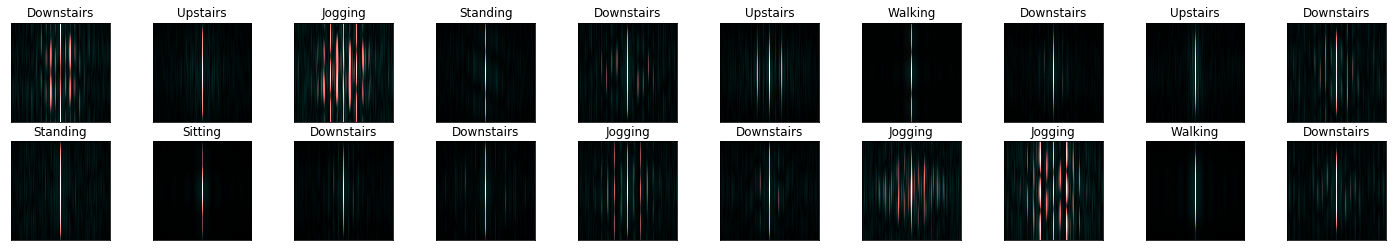

In [14]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
    ax.set_title(activities[labels[idx]])

In [15]:
import torchvision
from torch.optim import lr_scheduler

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.01
## Load the model 
model_conv = torchvision.models.inception_v3(pretrained='imagenet')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 6)

model_conv = model_conv.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_ft = optim.SGD(params=model_conv.parameters(), lr=LEARNING_RATE, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, dataset_sizes, num_epochs=25):    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                        
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(running_corrects.double(), dataset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
from sklearn.metrics import confusion_matrix 
# Evaluation methods
def evaluate_model(model, test_loader, criterion, classes):
    """Returns a confusion matrix"""
    
    # Check if model running on GPU
    train_on_gpu = torch.cuda.is_available()
    # Track test loss over all classes
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    cm_pred = []
    cm_data = []
    
    # Eval mode
    model.eval()
    
    # Iterate over test data
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute preducted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss 
        loss = criterion(output, target)
        # Update test loss
        test_loss += loss.item()*data.size(0)
        # Convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        for d in target.cpu().numpy():
            cm_data.append(d)
        for p in output.cpu().detach().numpy():
            cm_pred.append(np.argmax(p))
            
        # Calculate the confusion matrix
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i] - 1
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
    # calculate avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
#     cm = confusion_matrix(cm_data, cm_pred)
    return cm_data, cm_pred


In [18]:
model_ft = train_model(model_conv, data_loaders, criterion, optimizer_ft, exp_lr_scheduler, dataset_sizes, num_epochs=25)


Epoch 0/24
----------
tensor(9251., device='cuda:0', dtype=torch.float64) 13080
train Loss: 0.8346 Acc: 0.7073
tensor(2672., device='cuda:0', dtype=torch.float64) 3270
val Loss: 0.5099 Acc: 0.8171

Epoch 1/24
----------
tensor(9652., device='cuda:0', dtype=torch.float64) 13080
train Loss: 0.8532 Acc: 0.7379
tensor(2738., device='cuda:0', dtype=torch.float64) 3270
val Loss: 0.4873 Acc: 0.8373

Epoch 2/24
----------
tensor(9636., device='cuda:0', dtype=torch.float64) 13080
train Loss: 0.8985 Acc: 0.7367
tensor(2791., device='cuda:0', dtype=torch.float64) 3270
val Loss: 0.4275 Acc: 0.8535

Epoch 3/24
----------
tensor(9628., device='cuda:0', dtype=torch.float64) 13080
train Loss: 0.9414 Acc: 0.7361
tensor(2711., device='cuda:0', dtype=torch.float64) 3270
val Loss: 0.5790 Acc: 0.8291

Epoch 4/24
----------
tensor(9757., device='cuda:0', dtype=torch.float64) 13080
train Loss: 0.8894 Acc: 0.7459
tensor(2772., device='cuda:0', dtype=torch.float64) 3270
val Loss: 0.4655 Acc: 0.8477

Epoch 5/24

Test Loss: 0.387168

Test Accuracy of     0: 95% (2413/2525)
Test Accuracy of     1: 57% (523/911)
Test Accuracy of     2: 92% (2862/3078)
Test Accuracy of     3: 92% (416/448)
Test Accuracy of     4: 57% (406/704)
Test Accuracy of     5: 88% (331/374)

Test Accuracy (Overall): 86% (6951/8040)
---------------------------


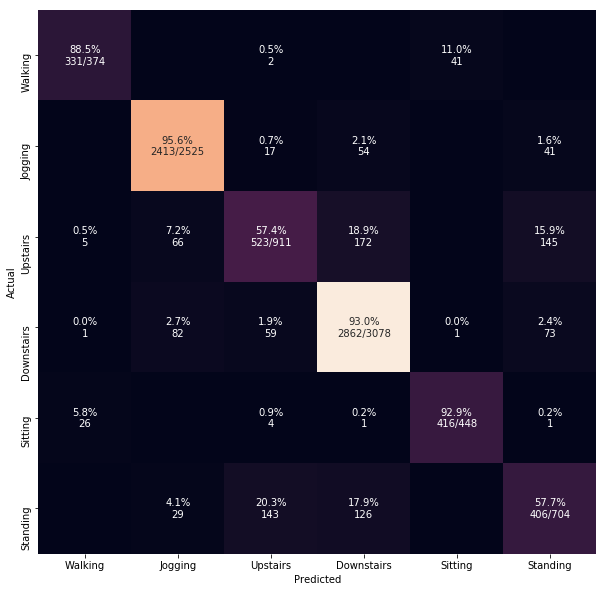

In [24]:
classes2 = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
classes1 = [0,1,2,3,4,5]
y_true, y_pred = evaluate_model(model_ft, test_loader, criterion, classes)
print('---------------------------')
cm_analysis(y_true, y_pred, classes1, classes2, ymap=None, figsize=(10,10))

